In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist
from scipy import stats as scs
import numpy as np
%config InlineBackend.figure_format = 'retina'

# The Curse of Dimensionality

Short lecture.

## Objectives

* Describe the curse of dimensionality
* List some ways to deal with it

## A deeply contrived example

A person has 100 personality boolean personality traits. You can have it, or not have it. Let's call them...

* $x_{i,1}$ : smart
* $x_{i,2}$ : sassy
* $x_{i,3}$ : regal
* $x_{i,4}$ : brave
* $x_{i,5}$ : euclitarian
* $x_{i,6}$ : fragilistic
* $x_{i,7}$ : thrombic
* $x_{i,8}$ : nondarian
* $x_{i,9}$ : lipsistic
* ...
* $x_{i,100}$ : hypsostic

Imagine that:
* A person can have a score on each personality characteristic ranging from 0 to 100. 
* The distribution is uniform.
* If someone has a greater than 50 score, they are considered "positive" for that personality trait.
* There is _no correlation_ between personality traits.

We're curious if someone **likes cookies**. The hidden model is that if someone is someone is smart or sassy **but not both**, then maybe they like cookies; we'll call that $y_{maybe}$. Then we ask if they're also regal. If they are either $y_{maybe}$ or regal **but not both**, then we will say that $y_{maybe}=true$. We repeat that process for every personality characteristic.

This odd scenario has nice properties:
* The independent variable is a deterministic function of the features.
  * Namely, it's $y_i = x_{i,1} \oplus x_{i,2} \oplus \ldots \oplus x_{i,n}$ (where $\oplus$ is the logical exclusive or operator.
* There are a large number of features.
* Every feature interacts with every other feature.
* The prevalance of the positive class is 0.5.
* There is no correlation between features.

In reality, similar situations - high-prevalance classes arising (mostly) deterministically from an interaction of a very large number of relatively independent features - are common in nature. For example:
 * Whether someone does well in school
 * Whether someone will die before turning 70
 * Whether someone likes thai food
 * Whether a business is profitable in the first year


In [52]:
# make an artificial data set

np.random.seed(42)

n_samples = 10000
n_features = 100
X = np.random.uniform( 100, size=(n_samples,n_features))
y = np.logical_xor.reduce( X>50, axis=1 )

In [12]:
X

array([[62.92052823,  5.87928367, 27.53259976, ..., 57.67343918,
        97.48350645, 89.31874873],
       [96.88851062, 36.99536928, 68.87875787, ..., 11.18608426,
        12.178444  , 22.79232096],
       [36.43886703, 91.67014347, 83.9987573 , ..., 78.63371828,
        38.33384289, 91.55060097],
       ...,
       [41.18213309, 49.7420848 , 79.33031372, ..., 21.687661  ,
         8.24714886, 70.18056032],
       [92.05505286,  2.10321256, 42.95292259, ..., 25.14297711,
        74.43270236, 50.96310162],
       [71.25008866, 29.02834355,  1.30134182, ..., 58.61087378,
        57.56154559,  7.98459376]])

In [13]:
y

array([ True, False, False, ..., False,  True, False])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [15]:
knn = KNeighborsClassifier(n_neighbors=20)

In [16]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [17]:
yhat = knn.predict(X_test)

In [18]:
accuracy_score(y_test, yhat)

0.5088

Pretty terrible!!! Especially considering there is, in fact, a method for predicting the output with perfect accuracy:

In [19]:
yhat = np.logical_xor.reduce( X_test>50, axis=1 )

In [20]:
accuracy_score(y_test, yhat)

1.0

**What is going on??**



The first item from the test set:

In [21]:
x_0 = X_test[0]
x_0

array([81.86527537, 35.91048442, 46.36850854, 95.69829626, 94.90251328,
        3.88076327, 68.09804443,  6.5639366 , 43.44417968, 81.69683701,
       56.85286609, 26.04963528,  6.05343231,  4.29549486, 73.30507136,
       80.16541436, 40.74444397, 91.66120265, 32.06844758, 41.56192204,
       69.89111624, 79.04028109,  1.30867662, 60.11214724, 37.09295783,
       27.31703108,  9.27709966, 29.35796206, 12.42652306, 68.84359038,
       93.09780989, 55.0377936 , 19.06277597, 45.55125771, 39.43401484,
       48.17508772, 97.2474135 , 65.69158729, 36.80770121, 66.23811394,
        2.39147047, 86.94206495, 27.56861821, 12.73619459, 35.4786028 ,
       72.03411135, 93.89967707, 22.27883001, 84.54667055, 32.8926461 ,
       51.21472748, 13.89498522, 55.59834627, 63.56322437, 57.34319869,
       77.51983685,  1.1940945 , 35.56320997, 96.29584738, 66.74085053,
       66.36595253, 70.62999957, 44.88121918, 60.46351265,  9.309259  ,
       72.15989858, 20.01693272, 24.85771416, 12.02891696, 61.03

This person is:

* smart
* not sassy
* not regal
* very brave
* very euclitarian
* absolutely not fragilistic
* thrombic
* not nondarian
* not lipsistic
* _yadda yadda yadda_
* not hypsostic

Do they like cookies?

In [22]:
np.logical_xor.reduce( x_0>50 )

False

But what if we use only their _nearest neighbors_ in the training set to guess?

In [23]:
_, ix = knn.kneighbors([x_0], 100)

Text(0.5, 1.0, 'personality characteristic test scores')

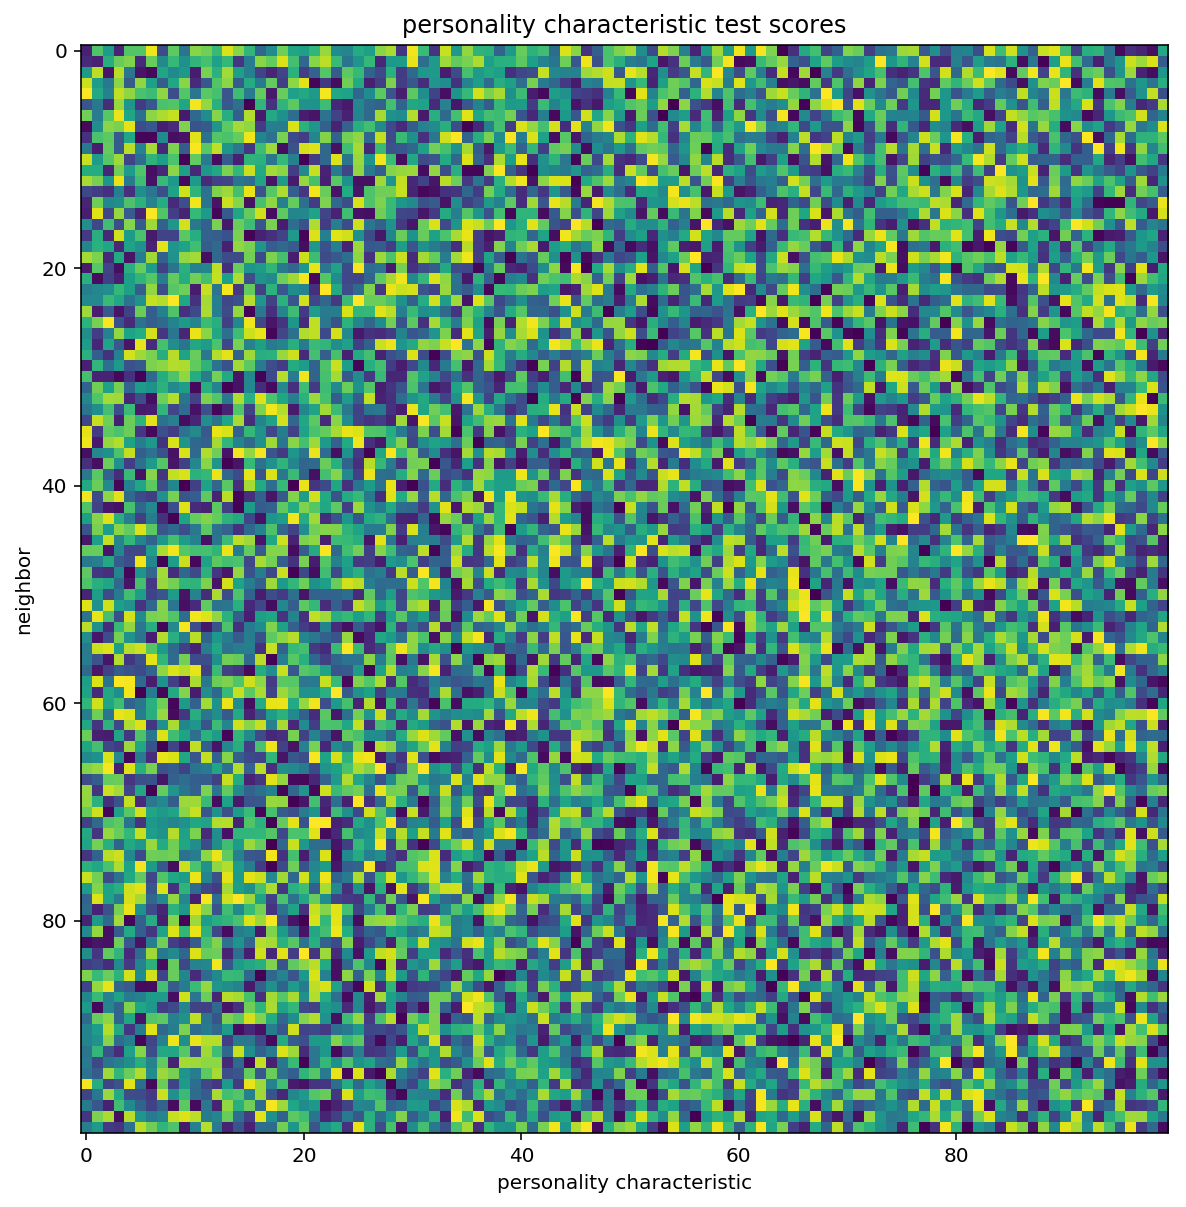

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow( (X[ix])[0] )
ax.set_ylabel("neighbor")
ax.set_xlabel("personality characteristic")
ax.set_title("personality characteristic test scores")

The 100 nearest neighbors seem to have nothing in common!!

In this example, in order to correctly classify a test point, there would need to be a point in the training set that has the **exact same combination of 100 personality characteristics**. If our training set were uniformly spaced we would need:

In [27]:
2**1 # for one personality charactersitics

2

In [28]:
2**2 # for two personality charactersitics

4

In [29]:
2**6 # for six personality charactersitics

64

In [30]:
2**100 # for one hundred personality charactersitics

1267650600228229401496703205376

The training set would have to be impractically large to contain a training point which would help us classify any given test point.

Forgive me to coin a phrase: **special snowflake syndrome**. If you consider a sample along enough dimensions, it is impractical to gather a training set in which it is likely that any other samples will be meaningfully close to it. Your samples become lonely special snowflakes.

## How to conquer the curse of dimensionality
### Collect more data
This is only practical for relatively low dimensions. For 15 dimensions, you can get good coverage over every dimension. For 1000 dimensions, collecting on the order of $2^{1000}$ is impractical.
### Reduce dimensionality
What if the information from 100 personality characteristics could be faithfully captured in 10? What if we don't need to know everything about a house to know how much it'll cost? This is a common way to reduce dimensionality to a tractable level.
### Rely on the Blessing of Non-Uniformity
Often a combination of non-unformity and correlation among features eliminates the problems associated with dimensionality without having to do anything at all. In fact, this is so common that the "curse of dimensionality" is often not a problem.
### Sometimes you can't
If your features are high-dimensional, have interactions, are uniformly distributed, and aren't strongly correlated, sometimes the learning task is simply intractable. Processes that you think of as "random" have these properties. For example, whether or not someone will develop stomach cancer; whether or not someone will get a job; whether or not a plane will crash. These processes may be completely deterministic, but developing a model of the interactions between all features would be intractable.

## The Blessing of non-uniformity

In [31]:
from sklearn.datasets import make_classification

In [35]:
np.random.seed(42)

n_feats = 100
n_useful = 5
n_redundant =n_feats-n_useful

scalefactor = 3.0
X, y = make_classification(n_samples=10000, 
                           n_features=n_feats, 
                           n_informative=n_useful, 
                           n_redundant=n_redundant,
                           scale=scalefactor,shift=50/scalefactor)

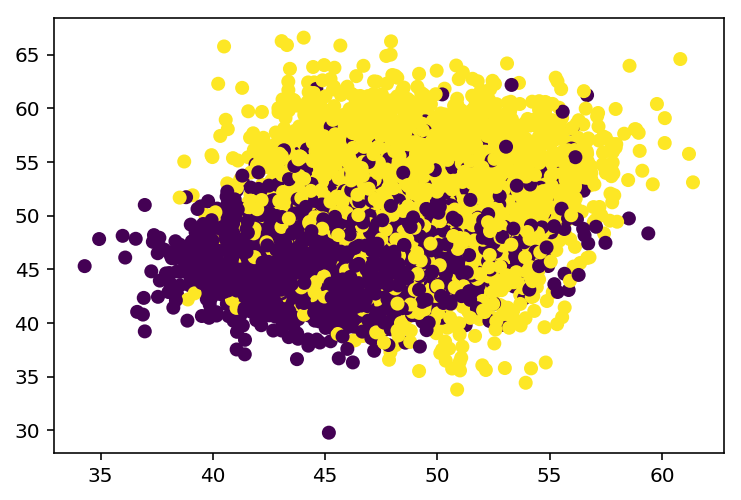

In [36]:
plt.scatter(X[:,0], X[:,9], c=y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [38]:
knn = KNeighborsClassifier(n_neighbors=20)

In [39]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='uniform')

In [40]:
yhat = knn.predict(X_test)

In [41]:
accuracy_score(y_test, yhat)

0.9492

In [42]:
x_0 = X_test[0]
x_0

array([46.35279986, 43.08352183, 59.53301713, 50.89268376, 54.32789812,
       39.82797677, 46.57422487, 50.3687538 , 53.15891809, 48.50818622,
       48.01674616, 40.48413481, 58.97426278, 46.82838178, 43.88273833,
       36.8707984 , 48.43576681, 42.39371352, 42.24072479, 44.3230088 ,
       51.86312748, 60.10170886, 39.47265868, 43.93802702, 55.59004254,
       50.85522577, 47.36456865, 34.22377722, 50.20741571, 49.03309277,
       57.99822506, 51.46754014, 65.3661039 , 41.08699781, 39.69168444,
       64.84769976, 57.83995566, 52.60706113, 54.14663231, 42.69949075,
       48.81694618, 42.97897405, 40.67145705, 58.88042357, 56.95016104,
       61.57204599, 51.71346847, 61.3576717 , 50.39549751, 60.08059481,
       40.04140297, 47.94878059, 47.27715122, 43.79700639, 62.23554332,
       37.85426519, 49.5024759 , 55.67584237, 40.62061328, 55.14953675,
       48.99059897, 56.08877487, 61.92111927, 44.53412714, 48.50908345,
       46.67297083, 50.34675427, 48.22038475, 62.74972632, 57.41

In [43]:
dists, ix = knn.kneighbors([x_0], 100)

Text(0.5, 1.0, 'Feature magnitude for 100 nearest neighbors')

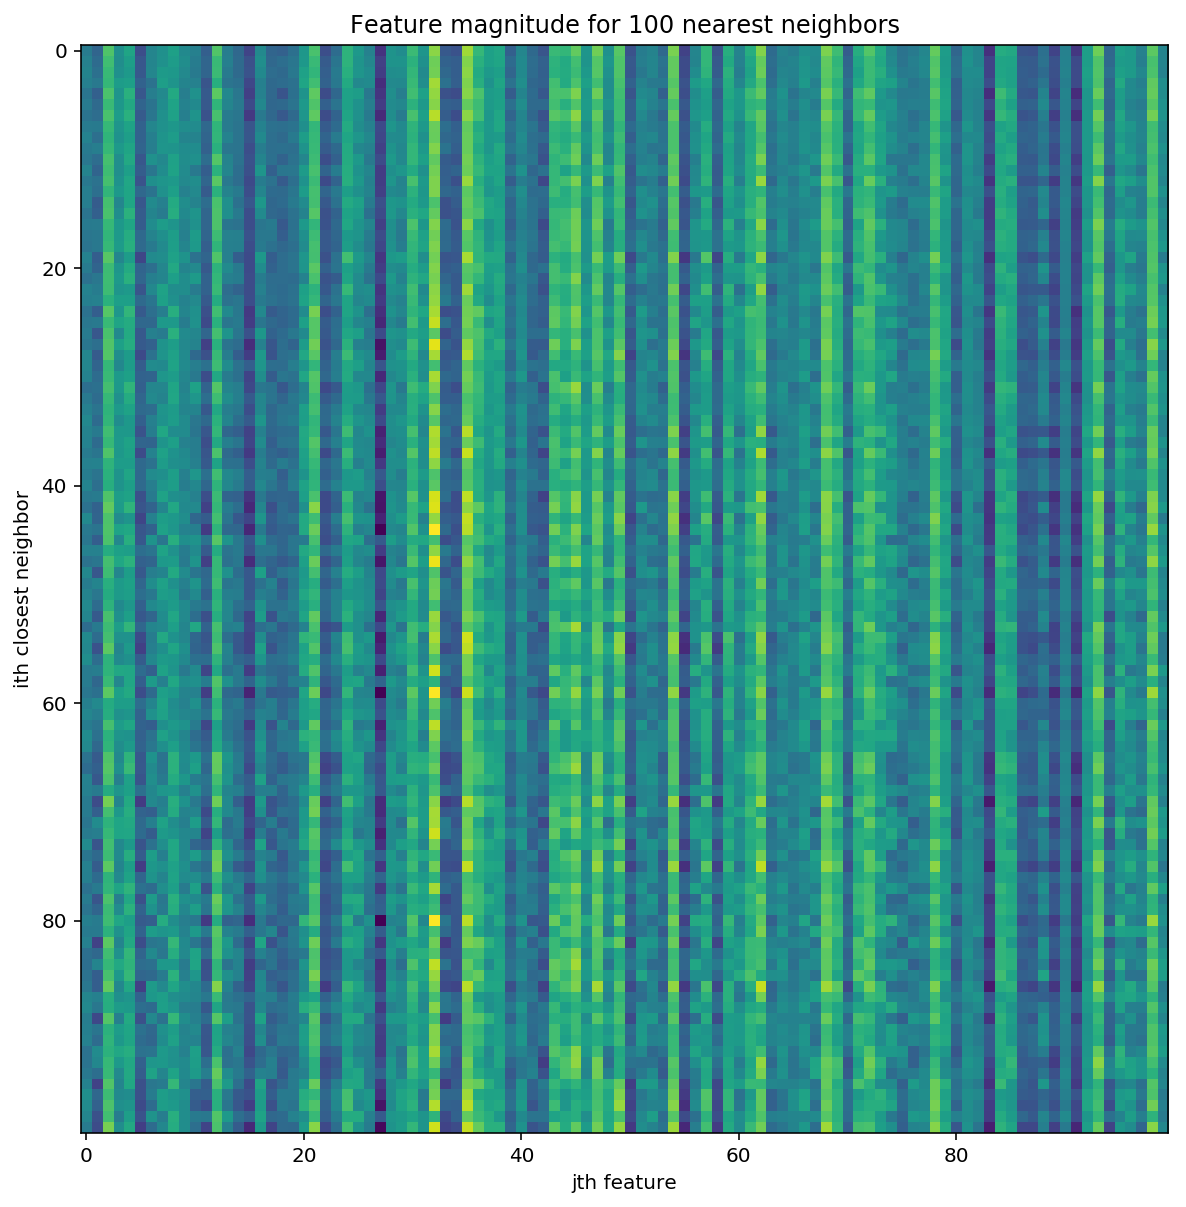

In [44]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow( X_train[ix][0] )
ax.set_ylabel("ith closest neighbor")
ax.set_xlabel("jth feature")
ax.set_title("Feature magnitude for 100 nearest neighbors")

### A real-world example

In [45]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

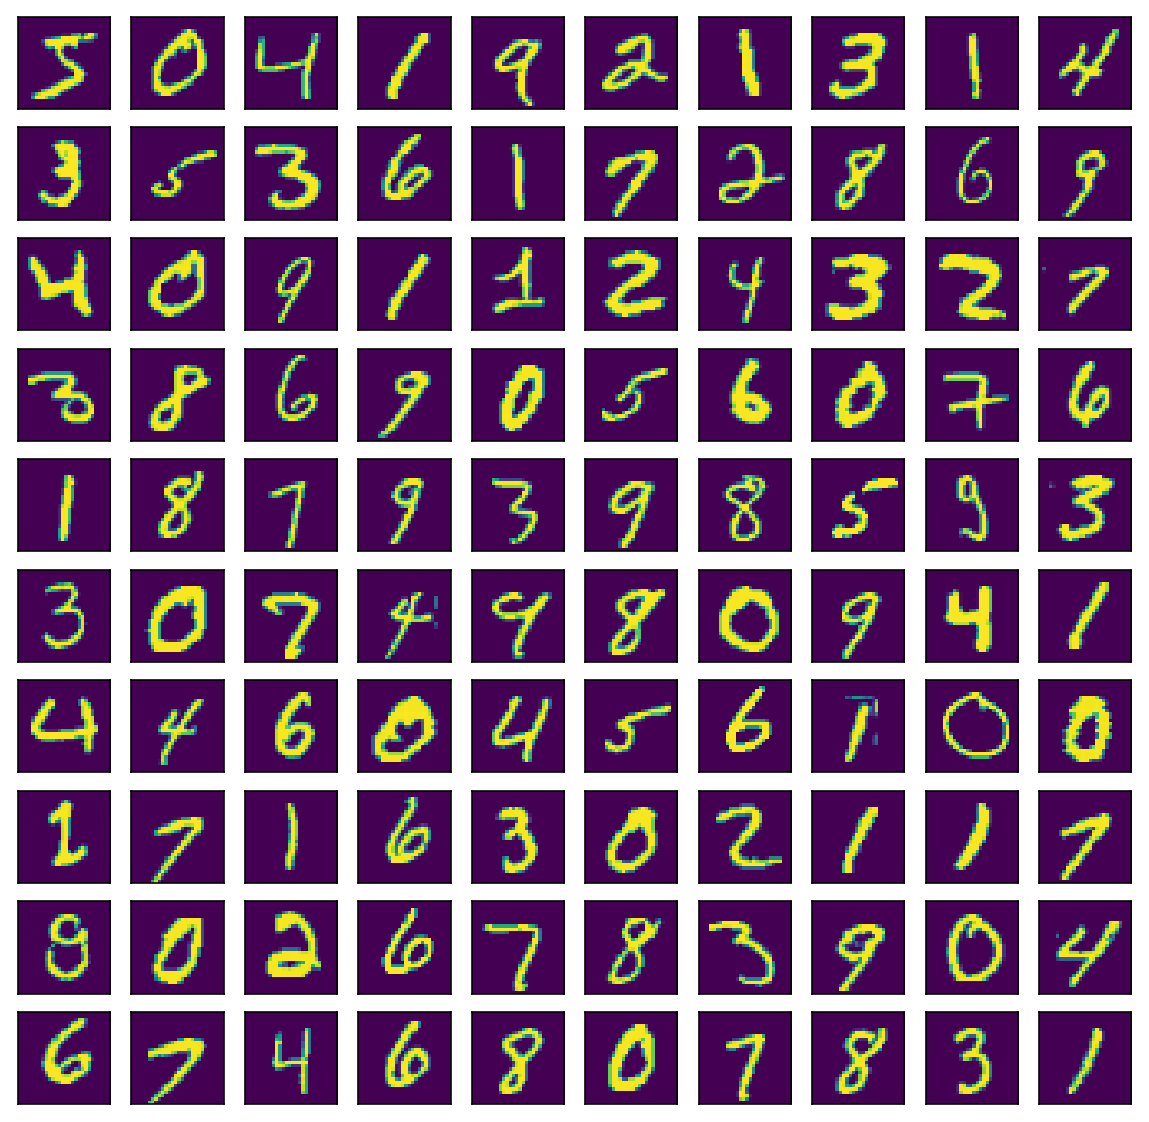

In [46]:
fig, axs = plt.subplots(10, 10, figsize=(10,10))
k = 0
for i in range(10):
    for j in range(10):
        ax = axs[i][j]
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow( X_train[k] )
        k += 1

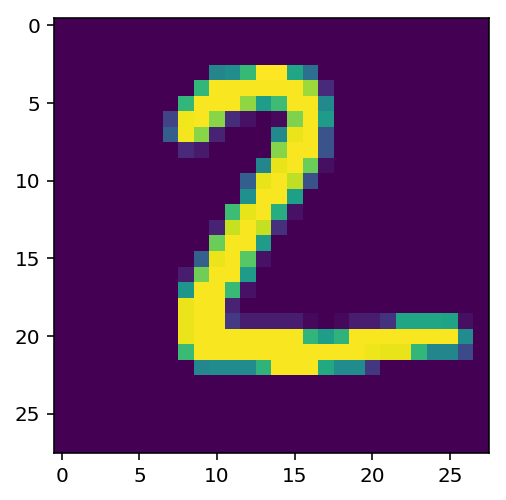

In [47]:
sample_ix = 1

plt.imshow( X_test[sample_ix] )

In [48]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_train_flat, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
dist, idx = knn.kneighbors(X_test_flat[sample_ix:sample_ix+1], n_neighbors=100)
idx = idx[0]

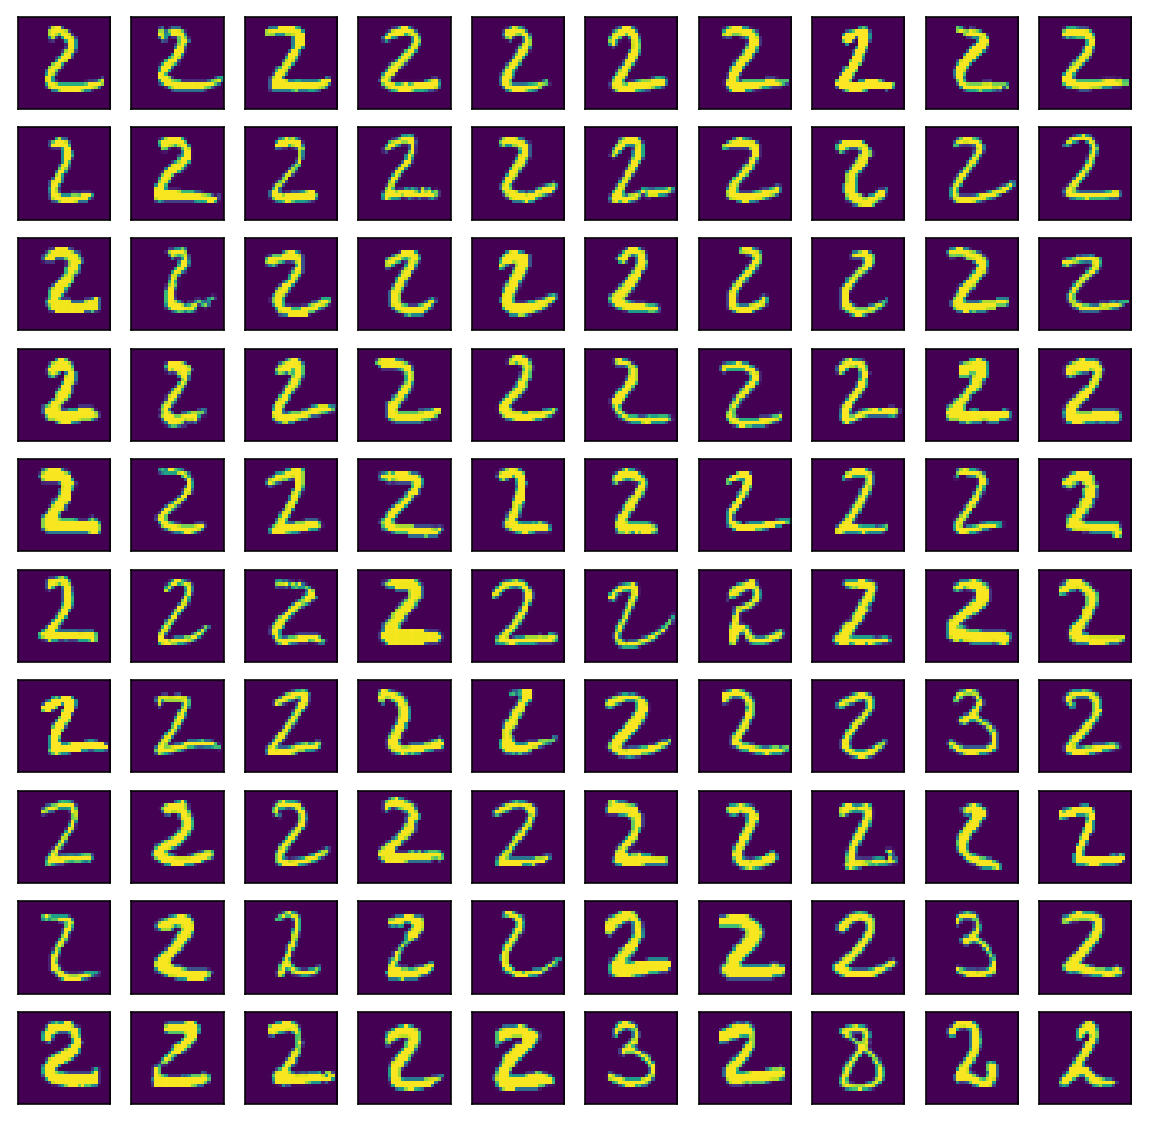

In [51]:
fig, axs = plt.subplots(10, 10, figsize=(10,10))
k = 0
for i in range(10):
    for j in range(10):
        ax = axs[i][j]
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow( X_train[ idx[k] ] )
        k += 1

In many high-dimensional datasets, the features are both correlated and non-uniform. Consequently, the nearest neighbors will in fact be meaningful and distances-based techniques will perform relatively well.